# Script to plot scaling of distance map

In [ ]:
PDB_PATH = "/scratch/amk19/ChromVAE/ChromVAE/Data/chromosome21_aligned.pdb"
AVERAGE_DISTANCE_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Training_Set/average_distances.npy"
SCALLING_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Training_Set/scaling_plot.png"

# In Silico Paths

In [ ]:
PDB_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Generated_Samples/Large_Latent_Dim/Beta_0.0001/generated_samples_training_distribution.pdb"
MODEL_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/trained_vae_model_RMSD_64_Latent_Dim.pt"
AVERAGE_DISTANCE_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/average_distances.npy"
DISTANCE_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/distance_map.png"
RADIUS_OF_GYRATION_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/radius_of_gyration.png"
RADIUS_OF_GYRATION_DISTRIBUTION_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/radius_of_gyration_distribution.png"
DISTRIBUTION_OUTPUT_1 = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/Distribution_of_Latent_Variable_1.png"
DISTRIBUTION_OUTPUT_2 = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/Distribution_of_Latent_Variable_2.png"
SCALLING_OUTPUT = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/scaling_plot.png"

# Load PDB

In [ ]:
from Bio.PDB import PDBParser
import numpy as np

def load_pdb_simple(pdb_path):
    """Load PDB file and return coordinates for each model."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_path)
    
    all_coords = []
    for model in structure:
        coords = []
        for atom in model.get_atoms():
            coords.append(atom.get_coord())
        all_coords.append(np.array(coords))
    
    return all_coords

# Usage
coords_list = load_pdb_simple(PDB_PATH)
print(f"Found {len(coords_list)} models")
print(f"First model has {len(coords_list[0])} atoms")

# Calculate Average Pairwise Distances

In [ ]:
import numpy as np
def compute_pairwise_distances(coords: np.ndarray) -> np.ndarray:
    """
    Compute pairwise distances between all atoms in a frame.
    Returns distance matrix of shape (N, N).
    """
    # Calculate all pairwise distances efficiently
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]  # (N, N, 3)
    distances = np.sqrt(np.sum(diff**2, axis=2))  # (N, N)
    return distances

# Calculate distances for first model to get shape
distances = compute_pairwise_distances(coords_list[0])
total_distances = distances.copy()

# Add distances from remaining models
for coords in coords_list[1:]:
    total_distances += compute_pairwise_distances(coords)

# Average across all models
average_distances = total_distances / len(coords_list)

# Save
np.save(AVERAGE_DISTANCE_PATH, average_distances)
print("Done! Saved to average_distances.npy")


# Load Average Pairwise Distances

In [ ]:
import numpy as np
# Load the saved average distances
average_distances = np.load(AVERAGE_DISTANCE_PATH)
print(f"Loaded distance matrix with shape: {average_distances.shape}")

# Calculate Mean for Each Diagonal

In [ ]:
D1 = []
err = []
for i in range(np.shape(average_distances)[0]):
    diag = np.diag(average_distances, k=i)
    D1.append(np.mean(diag))
    err.append(np.std(diag))

D = np.array(D1)
err = np.array(err)

NameError: name 'ScalarFormatter' is not defined

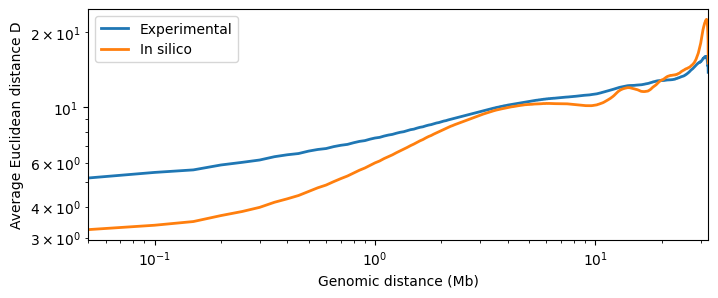

In [3]:
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt
# Compare experimental vs in silico scaling
EXPERIMENTAL_DISTANCE_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Training_Set/average_distances.npy"
IN_SILICO_DISTANCE_PATH = "/scratch/amk19/ChromVAE/ChromVAE/outputs/Large_Latent_Dim/average_distances.npy"
BIN_SIZE_BP = 50_000
MAX_MB = 35

experimental_distances = np.load(EXPERIMENTAL_DISTANCE_PATH)
in_silico_distances = np.load(IN_SILICO_DISTANCE_PATH)


def compute_scaling_profile(distance_matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    means = []
    stds = []
    for offset in range(distance_matrix.shape[0]):
        diag = np.diag(distance_matrix, k=offset)
        means.append(np.mean(diag))
        stds.append(np.std(diag))
    return np.array(means), np.array(stds)


def make_genomic_distance_axis(num_bins: int) -> np.ndarray:
    return np.arange(num_bins) * BIN_SIZE_BP / 1e6


D_exp, err_exp = compute_scaling_profile(experimental_distances)
D_silico, err_silico = compute_scaling_profile(in_silico_distances)

gen_dist_exp = make_genomic_distance_axis(D_exp.shape[0])
gen_dist_silico = make_genomic_distance_axis(D_silico.shape[0])

max_idx = min((gen_dist_exp <= MAX_MB).nonzero()[0].max(), (gen_dist_silico <= MAX_MB).nonzero()[0].max())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.loglog(gen_dist_exp[1:max_idx + 1], D_exp[1:max_idx + 1], color="C0", linewidth=2, label="Experimental")
ax.loglog(gen_dist_silico[1:max_idx + 1], D_silico[1:max_idx + 1], color="C1", linewidth=2, label="In silico")

ax.set_xlabel("Genomic distance (Mb)")
ax.set_ylabel("Average Euclidean distance D")
ax.set_xlim(gen_dist_exp[1], gen_dist_exp[max_idx])
ax.legend()

ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)

fig.tight_layout()



# Plot Scaling

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Compute genomic distances in Mb
gen_dist = np.arange(average_distances.shape[0]) * 50000 / 1e6

# Find last index <= 35 Mb
max_mb = 35
max_idx = (gen_dist <= max_mb).nonzero()[0].max()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))

ax.loglog(gen_dist[1:max_idx+1], D[1:max_idx+1], color='C0', label='Average Distance D', linewidth=2)
# ax.fill_between(gen_dist[1:max_idx+1], D[1:max_idx+1] - err[1:max_idx+1], D[1:max_idx+1] + err[1:max_idx+1], color='C0', alpha=0.3)

ax.legend()
ax.set_xlabel('Genomic distance (Mb)')
ax.set_ylabel('Average Euclidean distance D')
ax.set_xlim(gen_dist[1], gen_dist[max_idx])

# Change x-axis labels to decimals
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)

fig.tight_layout()
fig.savefig(SCALLING_OUTPUT, dpi=400)